In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image
import math
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F

from itertools import count
from collections import defaultdict

import sklearn
import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

import scipy.io

import collections
import PIL
import tqdm

from LLR_classifier import *

DEBUG = False

In [2]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 100
z_dim = 128

In [3]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)
    
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Encoder(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(Encoder, self).__init__()

        self.nc = nc
        self.z_dim = z_dim

        self.main = nn.Sequential(
            nn.Conv2d(nc, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            View((-1, 1024*4*4)),
            nn.Linear(1024*4*4, z_dim)
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)


    def forward(self, x):
        x = self.main(x)
        return x


class Decoder(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(Decoder, self).__init__()
        
        self.nc = nc
        self.z_dim = z_dim
        
        self.main = nn.Sequential(
            nn.Linear(z_dim, 1024*8*8),
            View((-1, 1024, 8, 8)),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, nc, 1)
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)


    def forward(self, x):
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super(Discriminator, self).__init__()
        
        self.z_dim = z_dim
        
        self.main = nn.Sequential(
            nn.Linear(self.z_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 1)
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        dis = self.main(x)
        return dis

In [4]:
enc = Encoder(z_dim=128, nc=3).to(device)
dec = Decoder(z_dim=128, nc=3).to(device)
dis = Discriminator(z_dim=128).to(device)

enc.load_state_dict(torch.load('saved_model_x1/encoder.pth'))
dec.load_state_dict(torch.load('saved_model_x1/decoder_.pth'))
dis.load_state_dict(torch.load('saved_model_x1/discriminator_.pth'))

/home/irfandw/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
#Train image directory
train_path = '/home/irfandw/Works/dataset/data_aligned_resize/copy1/Training/Subjects/'

#Test image directory
test_path = '/home/irfandw/Works/dataset/data_aligned_resize/FRGC/Testing/Subjects/'


#Pair train of FRGC directory
pairs_path1 = 'pairs_new/train/shufflepairs_genuine.txt'
pairs_path2 = 'pairs_new/train/shufflepairs_train_impostor_new.txt'

#Pair test of FRGC directory
pairs_test1 = 'pairs_frgc/shufflepairs_FRGC_test_genuine.txt'
pairs_test2 = 'pairs_frgc/shufflepairs_FRGC_test_impostor.txt'
pairs_path3 = 'pairs_frgc/pairs_frgc.txt'


file_ext = 'png'

In [6]:
def read_pairs(pairs_filename, lfw_flag=True):
    pairs = []
    with open(pairs_filename, 'r') as f:
        if lfw_flag:
            for line in f.readlines()[1:]:
                pair = line.strip().split()
                pairs.append(pair)
        else:
            for line in f.readlines():
                pair = line.strip().split()
                pairs.append(pair)      
    return np.array(pairs)

In [7]:
#Load training pairs
pairs1 = read_pairs(pairs_path1, lfw_flag=False)
pairs2 = read_pairs(pairs_path2, lfw_flag=False)

#Load testing pairs
pairtest1 = read_pairs(pairs_test1, lfw_flag=False)
pairtest2 = read_pairs(pairs_test2, lfw_flag=False)
pairsx = read_pairs(pairs_path3, lfw_flag=False)

In [8]:
#Get list of path for training and testing pairs
def get_paths(directory, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = os.path.join(directory, pair[0], pair[1])
            path1 = os.path.join(directory, pair[0], pair[2])
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(directory, pair[0], pair[1])
            path1 = os.path.join(directory, pair[2], pair[3])
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list

In [9]:
#Load training and testing
path_list1, issame_list1 = get_paths(train_path, pairs1, file_ext)
path_list2, issame_list2 = get_paths(train_path, pairs2, file_ext)

path_list_test1, issame_list_test1 = get_paths(test_path, pairtest1, file_ext)
path_list_test2, issame_list_test2 = get_paths(test_path, pairtest2, file_ext)
path_list3, issame_list3 = get_paths(test_path, pairsx, file_ext)

In [10]:
#Ground truth
gt = np.asarray(issame_list3)
gt

array([ True,  True,  True, ..., False, False, False])

In [11]:
class LoadDataset(torch.utils.data.Dataset):

    def __init__(self, path_list, issame_list, transforms, split = 'test'):
        
        self.files = collections.defaultdict(list)
        self.split = split
        self.files[split] =  path_list
        self.pair_label = issame_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_file = self.files[self.split][index]
        img = PIL.Image.open(img_file)
        if DEBUG:
            print (img_file)
        im_out = self.transforms(img)
        return im_out

In [12]:
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [13]:
#Load training dataset
train_loader_gen = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list1, issame_list1, test_transform), 
                        batch_size=1, shuffle=False )

train_loader_im = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list2, issame_list2, test_transform), 
                        batch_size=1, shuffle=False )

In [14]:
#Load testing dataset
test_loader_gen = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list_test1, issame_list_test1, test_transform), 
                        batch_size=1, shuffle=False )

test_loader_im = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list_test2, issame_list_test2, test_transform), 
                        batch_size=1, shuffle=False )

In [15]:
enc.eval()
dec.eval()

Decoder(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=65536, bias=True)
    (1): View()
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): ConvTranspose2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

## Create Z_mat

In [16]:
recons_images = []
zgen_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(train_loader_gen):
        #datax,_ = data
        data = data.to(device)

        z_encoded = enc(data)
        decod = dec(z_encoded)

        recons_images.append(decod[0].cpu().numpy())
        zgen_.append(z_encoded[0].cpu().numpy())

In [17]:
recons_images_genuine_train = np.array(recons_images)
zgen_ = np.array(zgen_)

In [18]:
z_reshape1 = zgen_.reshape((-1,256))
z_reshape_rot1 = np.transpose(z_reshape1)
add_ones = np.ones((1,2400))
z_mat = np.concatenate((z_reshape_rot1, add_ones))
print(z_mat.shape)

(257, 2400)


## Z_nonmated

In [19]:
recons_images_impostor_train = []
zim_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(train_loader_im):
        #datax,_ = data
        data = data.to(device)

        z_encoded = enc(data)
        decod = dec(z_encoded)

        recons_images_impostor_train.append(decod[0].cpu().numpy())
        zim_.append(z_encoded[0].cpu().numpy())

In [20]:
recons_images_impostor_train = np.array(recons_images_impostor_train)
zim_ = np.array(zim_)

In [31]:
z_reshape2 = zim_.reshape((-1,256))
z_reshape_rot2 = np.transpose(z_reshape2)
add_zeros = np.zeros((1,2400))
z_nonmat = np.concatenate((z_reshape_rot2, add_zeros))
print(z_nonmat.shape)

## SAVE DATA

In [36]:
train = np.concatenate((z_mat, z_nonmat),axis=1)  #training data

scipy.io.savemat('result_FRGC/train_new_ae.mat', mdict={"X_tr": train})

train_with_binary = np.save('result_FRGC/train_bin_ae.npy', train)

## Testing genuine

In [21]:
recons_images_genuine_test = []
zgen_test_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader_gen):
        #datax,_ = data
        data = data.to(device)

        z_encoded = enc(data)
        decod = dec(z_encoded)

        recons_images_genuine_test.append(decod[0].cpu().numpy())
        zgen_test_.append(z_encoded[0].cpu().numpy())

In [22]:
recons_images_genuine_test = np.array(recons_images_genuine_test)
zgen_test_ = np.array(zgen_test_)

In [24]:
z_reshape2_test = zgen_test_.reshape((-1,256))
z_reshape_rot2_test = np.transpose(z_reshape2_test)

## Testing Impostor

In [25]:
recons_images_impostor_test = []
zim_test_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader_im):
        #datax,_ = data
        data = data.to(device)

        z_encoded = enc(data)
        decod = dec(z_encoded)

        recons_images_impostor_test.append(decod[0].cpu().numpy())
        zim_test_.append(z_encoded[0].cpu().numpy())

In [26]:
recons_images_impostor_test = np.array(recons_images_impostor_test)
zim_test_ = np.array(zim_test_)

In [27]:
z_reshape2_test = zim_test_.reshape((-1,256))
z_reshape_rot2_test = np.transpose(z_reshape2_test)

## SAVE DATA

In [43]:
#Save data
test_gen_pair = np.concatenate((z_reshape_rot1_test, z_reshape_rot2_test), axis=1)

scipy.io.savemat('result_FRGC/test_gen_pair_ae.mat', mdict={"X": test_gen_pair})

np.save('result_FRGC/test_gen_pair_ae.npy', test_gen_pair)

## LLR

In [28]:
train = np.load('result_FRGC/train_bin_aae.npy')
test = np.load('result_FRGC/test_gen_pair_aae.npy')

In [29]:
#Finding the best Ndc value
find = []

for i in range(128):
    M_global_hat, B_psinv, stdB_hat = train_LLR(train, Npc=128, Ndc=i)
    LLR = LLR_computation(test, M_global_hat, B_psinv, stdB_hat)
    
    roc_auc = sklearn.metrics.roc_auc_score(gt, LLR[0])

    find.append(roc_auc)

find = np.array(find)
print(np.max(find))
print(np.where(find == np.max(find)))

0.8170366559975613
(array([119]),)


In [30]:
M_global_hat, B_psinv, stdB_hat = train_LLR(train, Npc=128, Ndc=119)

In [31]:
LLR = LLR_computation(test, M_global_hat, B_psinv, stdB_hat)
#print(LLR)
print(LLR[0].shape)

(3240,)


ROC-AUC: 0.8170


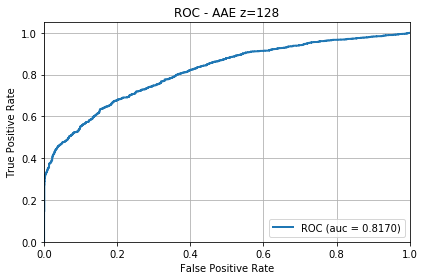

In [32]:
roc_auc = sklearn.metrics.roc_auc_score(gt, LLR[0])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(gt, LLR[0])
print ('ROC-AUC: %.04f' % roc_auc)
# Plot and save ROC curve
fig = plt.figure()
plt.title('ROC - AAE z=128')
plt.plot(fpr, tpr, lw=2, label='ROC (auc = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()